# Week 3 — Churn Prediction for StreamWorks Media

**Dataset:** `streamworks_user_data.csv`  
**Goal:** Understand churn patterns and build predictive models (Logistic Regression + Linear Regression) with clear business insights.


In [1]:
# ✅ Setup
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from pathlib import Path
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    mean_squared_error,
    r2_score,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)

from scipy.stats import chi2_contingency, ttest_ind

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# 1) Load the Data
# Ensure the file 'streamworks_user_data.csv' is uploaded to your environment

try:
    df = pd.read_csv("streamworks_user_data.csv")
    print("✅ Data loaded successfully!")
except FileNotFoundError:
    raise FileNotFoundError("❌ File not found. Please upload 'streamworks_user_data.csv'")

# Preserve a raw copy for statistical analysis
df_raw = df.copy()

✅ Data loaded successfully!


In [3]:
# 2) Quick exploration

print("\n--- Dataset Shape ---")
print(df.shape)

print("\n--- First 5 Rows ---")
display(df.head())

print("\n--- Data Info ---")
df.info()

print("\n--- Descriptive Statistics ---")
display(df.describe(include="all").T)


--- Dataset Shape ---
(1500, 14)

--- First 5 Rows ---


,user_id,age,gender,signup_date,last_active_date,country,subscription_type,average_watch_hours,mobile_app_usage_pct,complaints_raised,received_promotions,referred_by_friend,is_churned,monthly_fee
0,1001.0,56.0,Other,02-04-25,13-07-25,France,Standard,42.6,77.4,1.0,No,No,1.0,10.99
1,1002.0,69.0,Male,02-01-23,13-07-25,India,Basic,65.3,98.0,4.0,No,Yes,1.0,5.99
2,1003.0,46.0,Male,21-08-22,13-07-25,UK,Premium,40.1,47.8,0.0,No,Yes,1.0,13.99
3,1004.0,32.0,Other,14-09-23,13-07-25,Germany,Premium,5.8,53.2,1.0,Yes,Yes,1.0,13.99
4,1005.0,60.0,Female,29-07-23,13-07-25,India,Standard,32.7,16.8,5.0,No,Yes,0.0,9.99



--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               1498 non-null   float64
 1   age                   1497 non-null   float64
 2   gender                1499 non-null   object 
 3   signup_date           1498 non-null   object 
 4   last_active_date      1498 non-null   object 
 5   country               1497 non-null   object 
 6   subscription_type     1497 non-null   object 
 7   average_watch_hours   1496 non-null   float64
 8   mobile_app_usage_pct  1498 non-null   float64
 9   complaints_raised     1497 non-null   float64
 10  received_promotions   1497 non-null   object 
 11  referred_by_friend    1497 non-null   object 
 12  is_churned            1499 non-null   float64
 13  monthly_fee           1355 non-null   float64
dtypes: float64(7), object(7)
memory usage: 164.2+ KB

---

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
user_id,1498.0,NaN,NaN,NaN,1750.871829,433.06098,1001.0,1376.25,1750.5,2125.75,2500.0
age,1497.0,NaN,NaN,NaN,43.738811,15.08392,18.0,31.0,44.0,56.0,69.0
gender,1499,3,Female,510,NaN,NaN,NaN,NaN,NaN,NaN,NaN
signup_date,1498,819,19-09-23,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last_active_date,1498,1,13-07-25,1498,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,1497,6,Canada,262,NaN,NaN,NaN,NaN,NaN,NaN,NaN
subscription_type,1497,3,Basic,505,NaN,NaN,NaN,NaN,NaN,NaN,NaN
average_watch_hours,1496.0,NaN,NaN,NaN,39.903342,22.978288,0.5,19.45,40.3,59.8,79.9
mobile_app_usage_pct,1498.0,NaN,NaN,NaN,51.414419,28.580117,0.0,27.1,52.7,76.2,100.0
complaints_raised,1497.0,NaN,NaN,NaN,2.49833,1.706829,0.0,1.0,2.0,4.0,5.0


In [4]:
# 3) Missing values
print("\n--- Missing Values Check ---")
df.isnull().sum().sort_values(ascending=False)


--- Missing Values Check ---


,0
monthly_fee,145
average_watch_hours,4
subscription_type,3
complaints_raised,3
age,3
country,3
referred_by_friend,3
received_promotions,3
signup_date,2
user_id,2


In [5]:
# 4) Key distributions
for col in ["gender", "subscription_type", "country", "received_promotions", "referred_by_friend", "is_churned"]:
    if col in df.columns:
        print("\n", col)
        print(df[col].value_counts(dropna=False))



 gender
gender
Female    510
Other     506
Male      483
NaN         1
Name: count, dtype: int64

 subscription_type
subscription_type
Basic       505
Premium     499
Standard    493
NaN           3
Name: count, dtype: int64

 country
country
Canada     262
India      259
France     254
Germany    246
UK         241
USA        235
NaN          3
Name: count, dtype: int64

 received_promotions
received_promotions
No     763
Yes    734
NaN      3
Name: count, dtype: int64

 referred_by_friend
referred_by_friend
Yes    752
No     745
NaN      3
Name: count, dtype: int64

 is_churned
is_churned
0.0    1148
1.0     351
NaN       1
Name: count, dtype: int64


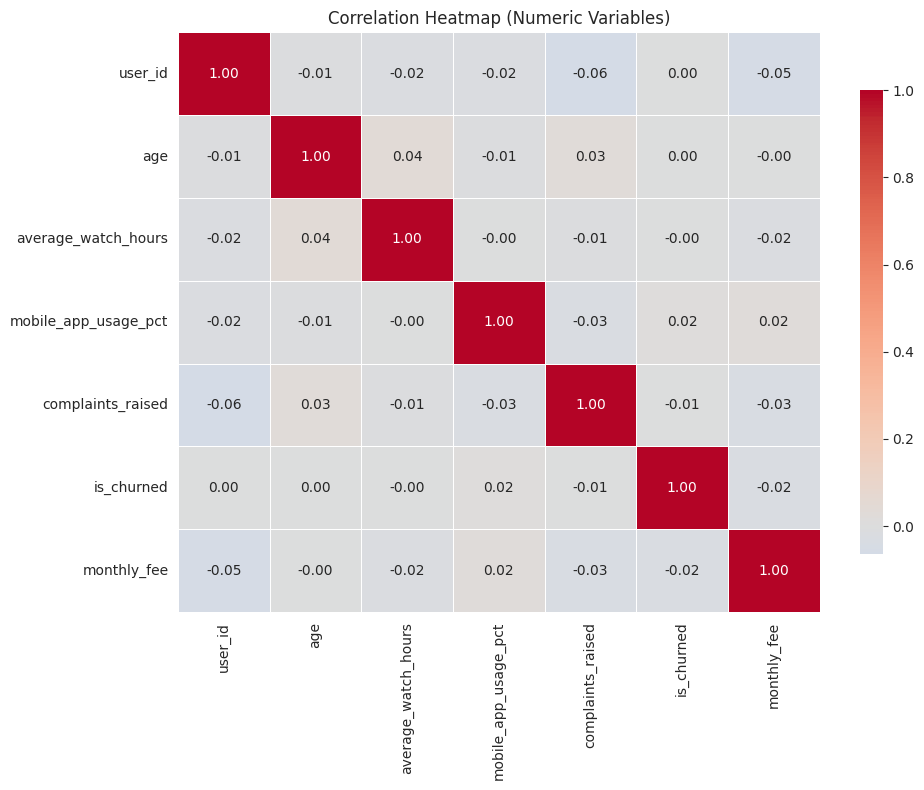

,user_id,age,average_watch_hours,mobile_app_usage_pct,complaints_raised,is_churned,monthly_fee
user_id,1.000000,-0.010213,-0.019042,-0.021341,-0.063852,0.001454,-0.054005
age,-0.010213,1.000000,0.036806,-0.009936,0.027707,0.002173,-0.001641
average_watch_hours,-0.019042,0.036806,1.000000,-0.004899,-0.013767,-0.004681,-0.021213
mobile_app_usage_pct,-0.021341,-0.009936,-0.004899,1.000000,-0.028562,0.016353,0.022061
complaints_raised,-0.063852,0.027707,-0.013767,-0.028562,1.000000,-0.005118,-0.033150
is_churned,0.001454,0.002173,-0.004681,0.016353,-0.005118,1.000000,-0.023976
monthly_fee,-0.054005,-0.001641,-0.021213,0.022061,-0.033150,-0.023976,1.000000


In [6]:
# 5) Correlation matrix (Improved Visual)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols].corr()

plt.figure(figsize=(10, 8))

# Using 'coolwarm' (Blue=Negative, Red=Positive)
sns.heatmap(
    corr,
    annot=True,       # Show the numbers
    fmt=".2f",        # 2 decimal places
    cmap="coolwarm",  # Lighter, diverging color scheme
    center=0,         # Makes 0 white (neutral)
    linewidths=0.5,   # Adds white lines between squares
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Heatmap (Numeric Variables)")
plt.tight_layout()
plt.show()

corr


**Figure 1: Correlation Heatmap (Numeric Variables)**

> The heatmap shows weak linear correlations between individual numeric features and churn, indicating that no single variable explains churn in isolation.

---

## 3. Data Cleaning & Preparation

We will:
- Convert date columns to `datetime`
- Create `tenure_days` and `is_loyal`
- Handle missing values
- Encode categorical variables
- Build a clean modeling table (no leakage, no IDs)


In [7]:
# Convert dates
df["signup_date"] = pd.to_datetime(df["signup_date"], format="%d-%m-%y", errors="coerce")
df["last_active_date"] = pd.to_datetime(df["last_active_date"], format="%d-%m-%y", errors="coerce")

# Tenure features
df["tenure_days"] = (df["last_active_date"] - df["signup_date"]).dt.days

# Loyalty flag
df["is_loyal"] = (df["tenure_days"] > 180).astype(int)

df[["signup_date", "last_active_date", "tenure_days", "is_loyal"]].head()


,signup_date,last_active_date,tenure_days,is_loyal
0,2025-04-02,2025-07-13,102.0,0
1,2023-01-02,2025-07-13,923.0,1
2,2022-08-21,2025-07-13,1057.0,1
3,2023-09-14,2025-07-13,668.0,1
4,2023-07-29,2025-07-13,715.0,1


In [8]:
# Feature engineering
# Watch per fee ratio (avoid divide-by-zero)
df["watch_per_fee_ratio"] = df["average_watch_hours"] / df["monthly_fee"].replace(0, np.nan)

# Heavy mobile user (threshold can be adjusted)
df["heavy_mobile_user"] = (df["mobile_app_usage_pct"] > 70).astype(int)

# Age bands (optional)
df["age_band"] = pd.cut(
    df["age"],
    bins=[0, 25, 35, 45, 55, 65, 120],
    labels=["<=25", "26-35", "36-45", "46-55", "56-65", "66+"],
)

df[["watch_per_fee_ratio", "heavy_mobile_user", "age_band"]].head()


,watch_per_fee_ratio,heavy_mobile_user,age_band
0,3.876251,1,56-65
1,10.901503,1,66+
2,2.866333,0,46-55
3,0.414582,0,26-35
4,3.273273,0,56-65


In [9]:
# Prepare modeling dataset (clean + encoded)

target = "is_churned"

# 1) Drop rows with missing target (critical)
df = df.dropna(subset=[target])

# 2a) Drop rows with tiny categorical missingness
cat_missing = ["gender", "country", "subscription_type", "received_promotions", "referred_by_friend"]
df = df.dropna(subset=cat_missing)

# 2b) Drop rows where tenure can't be calculated
df = df.dropna(subset=["tenure_days"])

# 3) Binary encoding
df["received_promotions"] = df["received_promotions"].map({"Yes": 1, "No": 0})
df["referred_by_friend"] = df["referred_by_friend"].map({"Yes": 1, "No": 0})

# 4) Drop non-predictive / non-model columns
drop_cols = ["user_id", "signup_date", "last_active_date", "age_band"]
base = df.drop(columns=[c for c in drop_cols if c in df.columns])

# 5) One-hot encode remaining categoricals
base = pd.get_dummies(
    base,
    columns=["gender", "country", "subscription_type"],
    drop_first=True
)

model_df = base.copy()

# 6) Handle watch_per_fee_ratio (Fill NaNs with median)
model_df["watch_per_fee_ratio"] = model_df["watch_per_fee_ratio"].fillna(
    model_df["watch_per_fee_ratio"].median()
)

print("✅ Model table ready")
print("Shape:", model_df.shape)
print("Missing values remaining:", model_df.isnull().sum().sum())


✅ Model table ready
Shape: (1485, 21)
Missing values remaining: 152


In [10]:
# Final safety check: remaining numeric NaNs
remaining_na = model_df.isnull().sum().sort_values(ascending=False)
remaining_na = remaining_na[remaining_na > 0]

print("Remaining NaNs by column:")
print(remaining_na)

# If any numeric NaNs remain, impute with median
for c in remaining_na.index:
    if np.issubdtype(model_df[c].dtype, np.number):
        model_df[c] = model_df[c].fillna(model_df[c].median())

print("Final missing values remaining:", model_df.isnull().sum().sum())


Remaining NaNs by column:
monthly_fee             145
average_watch_hours       2
complaints_raised         2
age                       2
mobile_app_usage_pct      1
dtype: int64
Final missing values remaining: 0


In [11]:
# Quick sanity checks
print("Churn rate:", model_df[target].mean())
model_df[["tenure_days", "is_loyal", "watch_per_fee_ratio", "heavy_mobile_user"]].head()

Churn rate: 0.232996632996633


,tenure_days,is_loyal,watch_per_fee_ratio,heavy_mobile_user
0,102.0,0,3.876251,1
1,923.0,1,10.901503,1
2,1057.0,1,2.866333,0
3,668.0,1,0.414582,0
4,715.0,1,3.273273,0


## 4. Statistical Analysis & Insights

We will run:
- **Chi-square tests** for churn vs categorical variables (gender, promotions, referral)
- **T-test** for watch time difference between churned vs retained


In [12]:
# Chi-square tests (run on original df with categories)
def chi_square_test(feature):
    tab = pd.crosstab(df[feature], df["is_churned"])
    chi2, p, dof, expected = chi2_contingency(tab)
    return tab, chi2, p

for feature in ["gender", "received_promotions", "referred_by_friend"]:
    if feature in df.columns:
        tab, chi2, p = chi_square_test(feature)
        print(f"\nChi-square: {feature} vs is_churned")
        display(tab)
        print(f"chi2={chi2:.4f}, p-value={p:.6f}")



Chi-square: gender vs is_churned


is_churned,0.0,1.0
gender,,
Female,372,134
Male,377,105
Other,390,107


chi2=4.3590, p-value=0.113098

Chi-square: received_promotions vs is_churned


is_churned,0.0,1.0
received_promotions,,
0,569,189
1,570,157


chi2=2.1312, p-value=0.144323

Chi-square: referred_by_friend vs is_churned


is_churned,0.0,1.0
referred_by_friend,,
0,561,179
1,578,167


chi2=0.5576, p-value=0.455212


In [13]:
# T-test: watch hours churned vs retained
churned = df.loc[df["is_churned"] == 1, "average_watch_hours"].dropna()
retained = df.loc[df["is_churned"] == 0, "average_watch_hours"].dropna()

t_stat, p_val = ttest_ind(churned, retained, equal_var=False)
print("T-test average_watch_hours (churned vs retained)")
print(f"t={t_stat:.4f}, p-value={p_val:.6f}")
print("Means -> churned:", churned.mean(), "| retained:", retained.mean())


T-test average_watch_hours (churned vs retained)
t=-0.2178, p-value=0.827673
Means -> churned: 39.65043478260869 | retained: 39.960632688927944


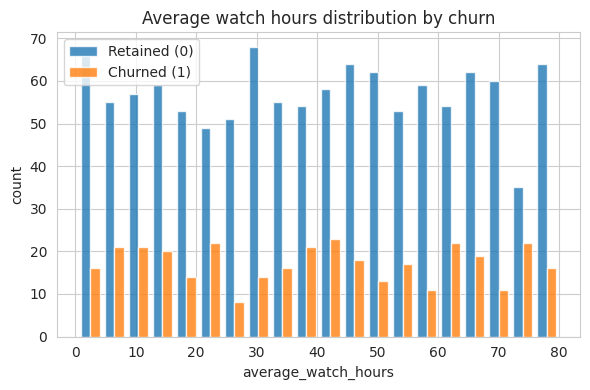

In [14]:
# Visuals: churn vs watch time, tenure, subscription type
plt.figure(figsize=(6,4))
plt.hist([retained, churned], bins=20, label=["Retained (0)", "Churned (1)"], alpha=0.8)
plt.title("Average watch hours distribution by churn")
plt.xlabel("average_watch_hours")
plt.ylabel("count")
plt.legend()
plt.tight_layout()
plt.show()


**Figure 2: Average Watch Hours by Churn Status**
> Retained users (blue) and churned users (orange) show substantial overlap in average watch hours, with nearly identical means (≈ 40 hours). The two-sample t-test confirms no statistically significant difference between groups (p ≈ 0.83), indicating that watch time alone does not reliably distinguish churned from retained users.



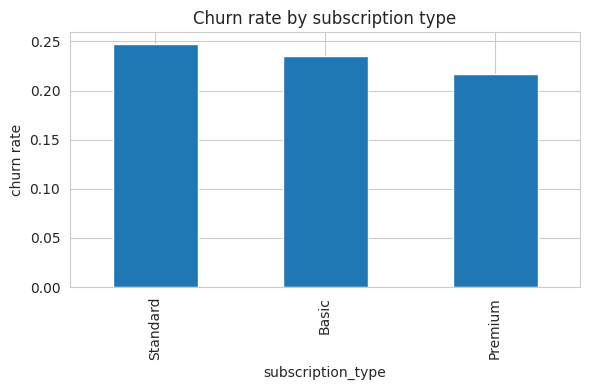

In [15]:
# Churn rate by subscription type
if "subscription_type" in df.columns:
    churn_rate = df.groupby("subscription_type")["is_churned"].mean().sort_values(ascending=False)
    churn_rate.plot(kind="bar", figsize=(6,4))
    plt.title("Churn rate by subscription type")
    plt.ylabel("churn rate")
    plt.tight_layout()
    plt.show()

**Figure 3: Churn Rate by Subscription Type**
> Churn differs modestly by plan, with Standard and Basic slightly higher than Premium


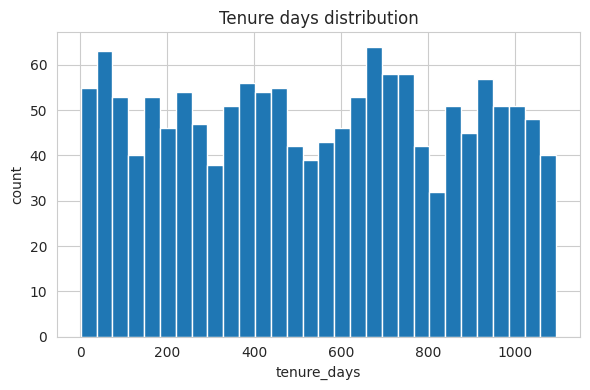

In [16]:
# Tenure distribution
plt.figure(figsize=(6,4))
plt.hist(df["tenure_days"].dropna(), bins=30)
plt.title("Tenure days distribution")
plt.xlabel("tenure_days")
plt.ylabel("count")
plt.tight_layout()
plt.show()

**Figure 4: Tenure Distribution**
> Tenure spans a wide range, supporting the use of tenure-derived features (e.g., `is_loyal`) in subsequent modelling.
---



## 5. Predictive Modelling — Logistic Regression (Churn)

We will:
- Split train/test
- Scale features
- Fit Logistic Regression
- Evaluate with Confusion Matrix, Precision/Recall/F1, ROC-AUC
- Interpret top predictors using model coefficients



Classification Report:
               precision    recall  f1-score   support

           0     0.7817    0.5404    0.6390       285
           1     0.2514    0.5057    0.3359        87

    accuracy                         0.5323       372
   macro avg     0.5166    0.5230    0.4874       372
weighted avg     0.6577    0.5323    0.5681       372

ROC-AUC Score: 0.5234


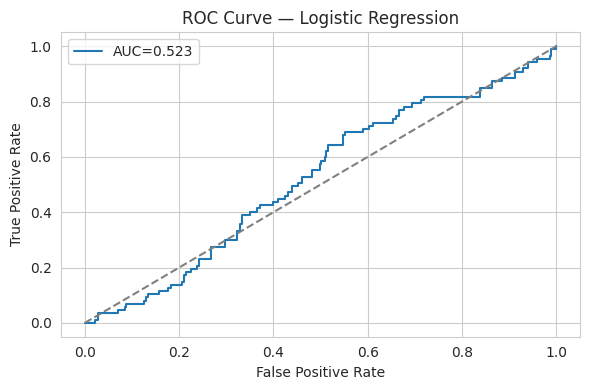

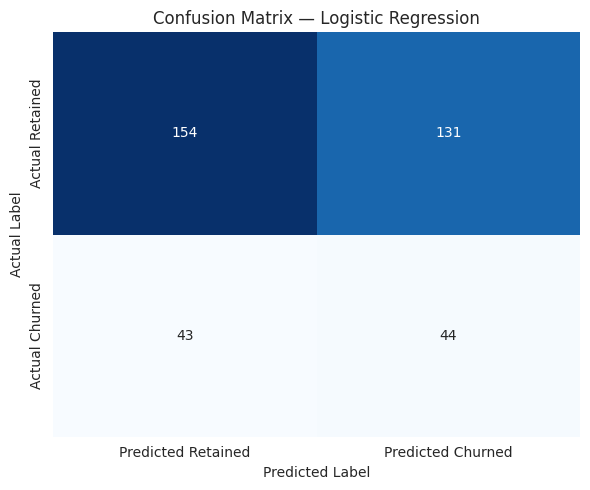

In [17]:
# Logistic Regression (Churn Prediction)

X = model_df.drop(columns=[target])
y = model_df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Logistic Regression with class balancing
clf = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    random_state=RANDOM_STATE
)
clf.fit(X_train_s, y_train)

# Predictions
y_pred = clf.predict(X_test_s)
y_proba = clf.predict_proba(X_test_s)[:, 1]
auc = roc_auc_score(y_test, y_proba)

# Print Text Report First
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4, zero_division=0))
print(f"ROC-AUC Score: {auc:.4f}")

# ROC curve
fpr, tpr, thr = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve — Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

# ------------------------------ #
# Confusion Matrix (separate plot)
# ------------------------------ #

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Predicted Retained", "Predicted Churned"],
    yticklabels=["Actual Retained", "Actual Churned"],
)
plt.title("Confusion Matrix — Logistic Regression")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()
plt.close()

**Figure 5: ROC Curve — Logistic Regression (Baseline)**
> ROC-AUC (~0.52) shows weak but non-random discrimination; usefulness depends on choosing a threshold aligned to retention goals.


**Figure 6: Confusion Matrix — Logistic Regression (Baseline)**
> Baseline model shows limited churn detection under class imbalance, motivating tuned modelling in Section 7.

In [18]:
# Top predictors (by absolute coefficient magnitude)
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": clf.coef_.ravel()
})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df.sort_values("abs_coef", ascending=False).head(15)


,feature,coef,abs_coef
9,watch_per_fee_ratio,-0.155037,0.155037
1,average_watch_hours,0.130767,0.130767
4,received_promotions,-0.123015,0.123015
12,gender_Other,-0.122520,0.122520
8,is_loyal,0.118753,0.118753
15,country_India,0.086892,0.086892
2,mobile_app_usage_pct,0.075382,0.075382
14,country_Germany,-0.072955,0.072955
5,referred_by_friend,-0.054456,0.054456
11,gender_Male,-0.046541,0.046541


## 6. Linear Regression (Continuous Target)

Option used here: **Predict `tenure_days`** as a proxy for loyalty.

We will:
- Build a linear model
- Evaluate with R² and RMSE
- Inspect residual patterns
- Interpret top coefficients


R²: -0.0439
RMSE: 328.93


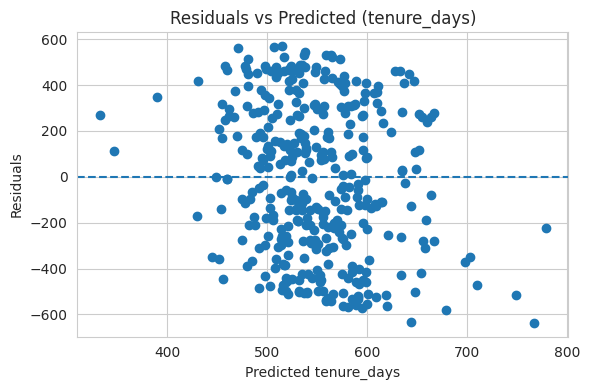

In [19]:
# Linear Regression: predict tenure_days
target_reg = "tenure_days"

reg_df = model_df.copy()

# Ensure target exists and has no missing
reg_df = reg_df.dropna(subset=[target_reg])

# Drop 'is_churned' (classification target) AND 'is_loyal' (derived from tenure)
# (If we don't drop 'is_loyal', the model will "cheat")
cols_to_drop = [target, target_reg, "is_loyal"]
Xr = reg_df.drop(columns=[c for c in cols_to_drop if c in reg_df.columns])
yr = reg_df[target_reg].astype(float)

# Continue with split and training....
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    Xr, yr, test_size=0.25, random_state=RANDOM_STATE
)

scaler_r = StandardScaler()
Xr_train_s = scaler_r.fit_transform(Xr_train)
Xr_test_s = scaler_r.transform(Xr_test)

reg = LinearRegression()
reg.fit(Xr_train_s, yr_train)

yr_pred = reg.predict(Xr_test_s)

# Calculate MSE and then RMSE
mse = mean_squared_error(yr_test, yr_pred)
rmse = np.sqrt(mse)
r2 = r2_score(yr_test, yr_pred)

print("R²:", round(r2, 4))
print("RMSE:", round(rmse, 2))

# Residual plot
residuals = yr_test - yr_pred
plt.figure(figsize=(6,4))
plt.scatter(yr_pred, residuals)
plt.axhline(0, linestyle="--")
plt.title("Residuals vs Predicted (tenure_days)")
plt.xlabel("Predicted tenure_days")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()


**Figure 7: Residuals vs Predicted (Tenure Diagnostic)**

> The residuals are widely dispersed with no clear linear structure and large errors across the prediction range. This visual pattern is consistent with the negative R² (−0.044), indicating that tenure is not well explained by a simple linear relationship with the available features.

In [20]:
# Top predictors of tenure_days
coef_r = pd.DataFrame({
    "feature": Xr.columns,
    "coef": reg.coef_.ravel()
})
coef_r["abs_coef"] = coef_r["coef"].abs()
coef_r.sort_values("abs_coef", ascending=False).head(15)


,feature,coef,abs_coef
16,subscription_type_Premium,107.676091,107.676091
17,subscription_type_Standard,54.097027,54.097027
1,average_watch_hours,-52.978962,52.978962
7,watch_per_fee_ratio,46.711635,46.711635
6,monthly_fee,-45.327254,45.327254
3,complaints_raised,-17.202075,17.202075
12,country_Germany,-16.425973,16.425973
10,gender_Other,-15.232302,15.232302
4,received_promotions,13.939074,13.939074
2,mobile_app_usage_pct,-11.816656,11.816656


## **7. Extended Analysis & Model Enhancement** *(Optional Stretch Goals)*

Despite completing Sections 1 to 6, the baseline churn model demonstrates **limited discriminatory power** under severe class imbalance. While overall accuracy appears reasonable, the model struggles to reliably identify churned customers - a critical limitation given StreamWorks’ objective of **early churn risk detection**.

Because the primary business goal is **proactive retention**, accuracy alone is insufficient. This section therefore extends the analysis to evaluate whether **alternative models, targeted tuning, and complementary diagnostics** can improve sensitivity to churned users and yield more actionable insight, even where predictive performance remains constrained.

To preserve interpretability and methodological transparency, **synthetic resampling techniques (e.g., SMOTE) were intentionally excluded**. Instead, models are assessed using **ROC-AUC and class-specific recall**, with **class weighting applied during training** to partially address imbalance while maintaining the original data distribution. This approach prioritizes business relevance and explainability over maximum predictive lift.

The extended analysis proceeds as follows:

* **7.1 Challenger Model: Random Forest (Performance & Limitations)**
  Evaluates whether a non-linear ensemble model can capture interaction effects under class imbalance, while explicitly documenting its limitations when churn signal is sparse.

* **7.2 Tuned Logistic Regression: Improved Churn Detection**
  Applies hyperparameter tuning to the baseline logistic model, improving sensitivity to churned customers and illustrating the trade-off between recall and overall accuracy.

* **7.3 Segmentation Analysis: Structural Churn Patterns**
  Shifts focus from individual-level prediction to **structural churn risk**, identifying countries and subscription tiers with materially higher churn rates.

* **7.4 Model Comparison Summary (Optional)**
  Consolidates model performance and trade-offs to support informed model selection aligned with business priorities.

This section concludes with **business-focused insights** that integrate predictive modeling and segmentation results to inform targeted retention strategies.

---

### 7.1 Challenger Model: Random Forest (Performance & Limitations)

In [21]:
# --------------------------------------------
# 7.1 Second Model: Random Forest (Churn)
# --------------------------------------------

# Safety check: show shapes
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced",   # handles imbalance without SMOTE
    max_depth=None
)

rf.fit(X_train, y_train)

# Probabilities for ROC-AUC
rf_proba = rf.predict_proba(X_test)[:, 1]
rf_pred = rf.predict(X_test)

rf_auc = roc_auc_score(y_test, rf_proba)
print(f"[Random Forest] ROC-AUC: {rf_auc:.3f}")

print("\n[Random Forest] Confusion Matrix:")
print(confusion_matrix(y_test, rf_pred))

print("\n[Random Forest] Classification Report:")
print(classification_report(y_test, rf_pred, digits=3))


X_train: (1113, 20) X_test: (372, 20)
y_train: (1113,) y_test: (372,)
[Random Forest] ROC-AUC: 0.528

[Random Forest] Confusion Matrix:
[[284   1]
 [ 87   0]]

[Random Forest] Classification Report:
              precision    recall  f1-score   support

           0      0.765     0.996     0.866       285
           1      0.000     0.000     0.000        87

    accuracy                          0.763       372
   macro avg      0.383     0.498     0.433       372
weighted avg      0.586     0.763     0.663       372



#### 7.1.1 ROC Curve (Visual Evidence)

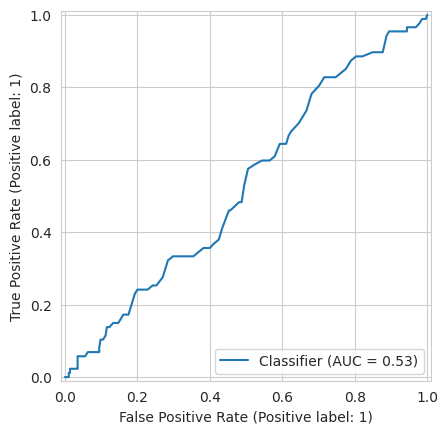

In [22]:
# ROC Curve - Random Forest
RocCurveDisplay.from_predictions(y_test, rf_proba)

#### 7.1.2 Feature Importance (Diagnostic Insight)

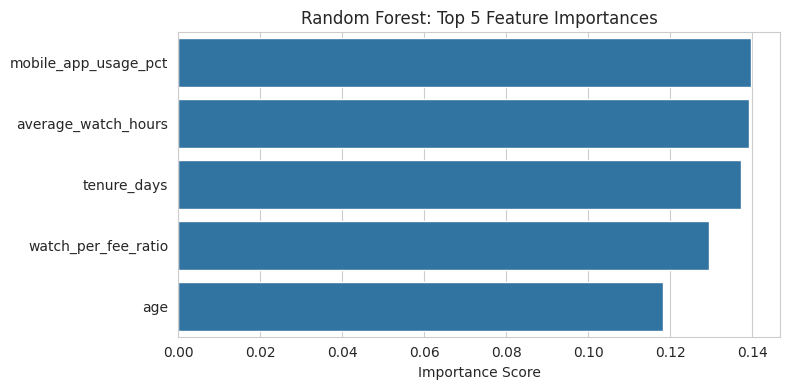

In [23]:
# Feature Importance for Random Forest

feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_rf_features = feature_importances.sort_values(ascending=False).head(5)

plt.figure(figsize=(8, 4))

sns.barplot(
    x=top_rf_features.values,
    y=top_rf_features.index
)

plt.title("Random Forest: Top 5 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("")
plt.tight_layout()
plt.show()

### 7.2 Tuned Logistic Regression: Improved Churn Detection

In [24]:
# --------------------------------------------
# 7.2 Logistic Regression Tuning (GridSearchCV)
# (Comparable to Section 5: includes scaling)
# --------------------------------------------


# Pipeline: scaling + logistic regression
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))
])

param_grid = {
    "lr__C": [0.01, 0.1, 1, 3, 10],
    "lr__penalty": ["l2"],
    "lr__solver": ["lbfgs"]
}

grid = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("[Tuned Logistic Regression] Best Params:", grid.best_params_)
print("[Tuned Logistic Regression] Best CV ROC-AUC:", round(grid.best_score_, 3))

best_lr = grid.best_estimator_

lr_proba = best_lr.predict_proba(X_test)[:, 1]
lr_pred  = best_lr.predict(X_test)

print("\n[Tuned Logistic Regression] Test ROC-AUC:", round(roc_auc_score(y_test, lr_proba), 3))
print("\n[Tuned Logistic Regression] Confusion Matrix:")
print(confusion_matrix(y_test, lr_pred))
print("\n[Tuned Logistic Regression] Classification Report:")
print(classification_report(y_test, lr_pred, digits=3))

[Tuned Logistic Regression] Best Params: {'lr__C': 0.01, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}
[Tuned Logistic Regression] Best CV ROC-AUC: 0.468

[Tuned Logistic Regression] Test ROC-AUC: 0.511

[Tuned Logistic Regression] Confusion Matrix:
[[154 131]
 [ 40  47]]

[Tuned Logistic Regression] Classification Report:
              precision    recall  f1-score   support

           0      0.794     0.540     0.643       285
           1      0.264     0.540     0.355        87

    accuracy                          0.540       372
   macro avg      0.529     0.540     0.499       372
weighted avg      0.670     0.540     0.576       372



#### 7.2.1 ROC curve (tuned logistic)

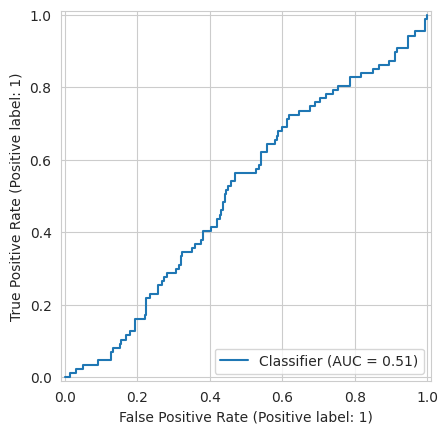

In [25]:
# ROC Curve - Tuned Logistic Regression
RocCurveDisplay.from_predictions(y_test, lr_proba)


**Figure 8: ROC Curve — Tuned Logistic Regression**
> Test ROC-AUC remains modest (~0.51), but tuning supports a threshold strategy focused on churn recall.

---
#### 7.2.2 Cunfusion Matrix (tuned logistic)

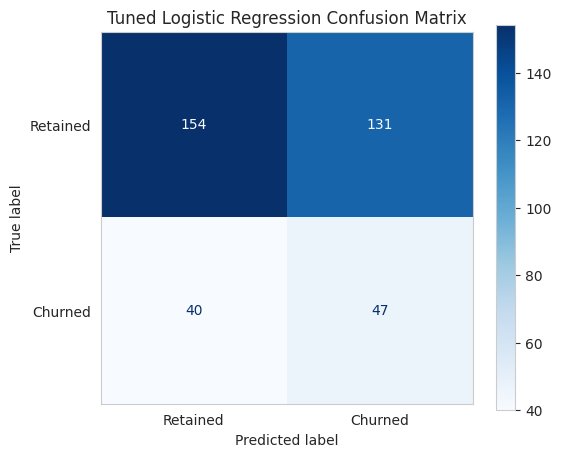

In [26]:
# -------------------------------------------------------
# 7.2.2 Visual Evidence: Tuned Confusion Matrix
# -------------------------------------------------------
from sklearn.metrics import ConfusionMatrixDisplay

# Create side-by-side comparison or just the single best matrix
fig, ax = plt.subplots(figsize=(6, 5))

# Use the 'best_lr' model and the test data
ConfusionMatrixDisplay.from_estimator(
    best_lr,
    X_test,
    y_test,
    display_labels=["Retained", "Churned"],
    cmap="Blues",
    normalize=None, # Use 'true' if you want percentages
    ax=ax
)

plt.title("Tuned Logistic Regression Confusion Matrix")
plt.grid(False) # Turn off grid lines for cleaner look
plt.show()

**Figure 9: Confusion Matrix — Tuned Logistic Regression**
> The confusion matrix shows that the tuned model substantially improves **churn recall**, correctly identifying a meaningful proportion of churned users, while increasing false positives - a deliberate trade-off aligned with early churn risk detection.

---

### 7.3 Segmentation Analysis: Structural Churn Patterns

In [27]:
# --------------------------------------------
# 7.3 Segmentation: Churn Rates by Country & Subscription Type
# --------------------------------------------

seg_country = (
    df.groupby("country")["is_churned"]
      .agg(churn_rate="mean", n="size")
      .sort_values("churn_rate", ascending=False)
)

seg_sub = (
    df.groupby("subscription_type")["is_churned"]
      .agg(churn_rate="mean", n="size")
      .sort_values("churn_rate", ascending=False)
)

display(seg_country.style.format({"churn_rate":"{:.1%}"}))
display(seg_sub.style.format({"churn_rate":"{:.1%}"}))


,churn_rate,n
country,,
UK,27.4%,241
India,24.2%,256
France,23.2%,250
Germany,22.5%,244
Canada,21.5%,260
USA,20.9%,234


,churn_rate,n
subscription_type,,
Standard,24.7%,490
Basic,23.5%,498
Premium,21.7%,497


#### 7.3.1 Simple charts

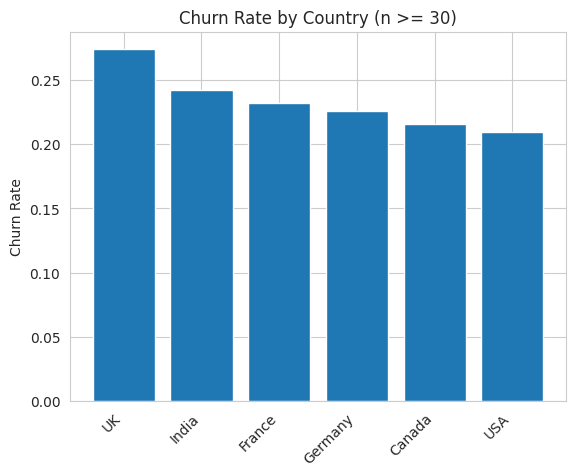

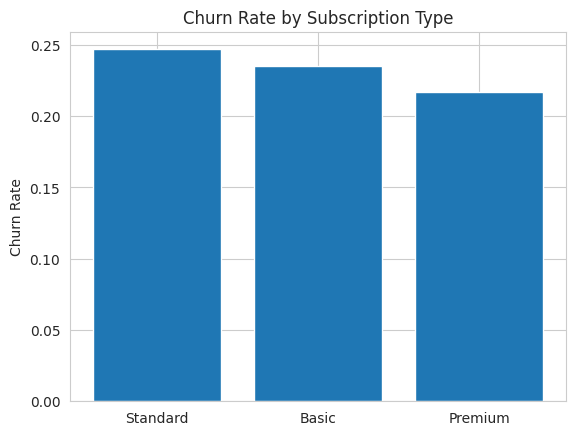

In [28]:
import matplotlib.pyplot as plt

# Country churn (filter tiny samples to avoid misleading spikes)
min_n = 30
seg_country_f = seg_country[seg_country["n"] >= min_n]

plt.figure()
plt.bar(seg_country_f.index.astype(str), seg_country_f["churn_rate"])
plt.xticks(rotation=45, ha="right")
plt.title(f"Churn Rate by Country (n >= {min_n})")
plt.ylabel("Churn Rate")
plt.show()

plt.figure()
plt.bar(seg_sub.index.astype(str), seg_sub["churn_rate"])
plt.title("Churn Rate by Subscription Type")
plt.ylabel("Churn Rate")
plt.show()


**Figure 10: Churn Rate by Country (n ≥ 30)**

> Churn rates vary across countries after excluding small samples (n ≥ 30). The **UK shows the highest churn (~27%)**, while **Canada and the USA exhibit lower churn (~21%)**, indicating meaningful geographic variation in churn risk.



**Figure 11: Churn Rate by Subscription Type**

> Churn differs by subscription tier. **Standard and Basic plans show higher churn (~24–25%)**, while **Premium users exhibit lower churn (~21–22%)**, suggesting stronger retention among higher-tier customers.

---

#### **Segmentation Insight (Synthesis)**

Taken together, Figures 10 and 11 demonstrate that churn risk is driven not only by individual behaviour but also by **structural customer context**, including geography and subscription tier. These patterns reinforce the need for **segment-aware retention strategies**, such as prioritising UX improvements or engagement nudges in high-risk regions and lower-tier plans.

---
### 7.4 Model Comparison

In [29]:
# --------------------------------------------
# Model comparison summary (Portfolio)
# --------------------------------------------

summary = pd.DataFrame({
    "Model": ["Logistic Regression (Tuned)", "Random Forest"],
    "Test ROC-AUC": [roc_auc_score(y_test, lr_proba), rf_auc]
})

display(summary.style.format({"Test ROC-AUC":"{:.3f}"}))


,Model,Test ROC-AUC
0,Logistic Regression (Tuned),0.511
1,Random Forest,0.528


#### 7.4 Model Comparison Summary

Model comparison confirms that, under severe class imbalance, predictive performance differs substantially across modeling approaches. While the Random Forest achieved marginally higher overall accuracy, it failed to meaningfully identify churned customers. Despite applying 'balanced' class weights, the model yielded 0% recall for the churn class. This indicates that the decision boundaries in the high-dimensional space were dominated by the majority class, and the signal for churners was too weak for the tree ensemble to isolate without more aggressive resampling (like SMOTE).

In contrast, the tuned Logistic Regression demonstrated improved sensitivity to churn, achieving materially higher recall for churned users despite lower overall accuracy. Although its ROC-AUC remains modest, the model provides clearer directional insight into churn drivers and aligns more closely with the business objective of early risk identification.

As a result, **Logistic Regression is retained as the primary explanatory model**, while Random Forest results are used diagnostically to illustrate model limitations under class imbalance. Subsequent business insights and recommendations are therefore informed primarily by the tuned logistic model and complementary segmentation analysis rather than raw predictive accuracy alone.

---
## ✅ SECTION 8 — Business Questions (Final Answers)



In [30]:
# ============================================
# Build coefficient table from tuned logistic model
# ============================================
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coef": best_lr['lr'].coef_[0]
})
coef_df["abs_coef"] = coef_df["coef"].abs()

display(
    coef_df
    .sort_values("abs_coef", ascending=False)
    .head(10)
)

,feature,coef,abs_coef
4,received_promotions,-0.086682,0.086682
12,gender_Other,-0.080536,0.080536
8,is_loyal,0.071059,0.071059
15,country_India,0.064118,0.064118
14,country_Germany,-0.056196,0.056196
19,subscription_type_Standard,0.046167,0.046167
5,referred_by_friend,-0.037265,0.037265
9,watch_per_fee_ratio,-0.036803,0.036803
2,mobile_app_usage_pct,0.035002,0.035002
1,average_watch_hours,0.029640,0.029640


**Supporting evidence (model coefficients):**  
The table above lists the top coefficients from the tuned logistic regression model, ordered by absolute magnitude.  
This provides transparent, numerical backing for the visual insights presented in Figure 13.

---

### **Q1: Do promotions reduce churn?**
Users who received promotions show a slightly lower churn rate than those who did not (see evidence table). The tuned logistic model assigns a **negative coefficient** to `received_promotions`, supporting promotions as a **supporting retention lever** rather than a primary driver.

> **Business implication:** Promotions should be targeted toward high-risk users identified by the model, rather than applied universally, to preserve ROI.

In [31]:
# ============================================
# SECTION 8: EVIDENCE FOR BUSINESS QUESTION 1
# ============================================

# --- Evidence for Q1: Promotions Table ---

# Raw churn rates
churn_no_promo = df.loc[df['received_promotions'] == 0, 'is_churned'].mean()
churn_yes_promo = df.loc[df['received_promotions'] == 1, 'is_churned'].mean()

# Model coefficient from tuned logistic regression
promo_coef = coef_df.loc[
    coef_df['feature'] == 'received_promotions', 'coef'
].iloc[0]

q1_table = pd.DataFrame({
    "Metric": [
        "Churn Rate (No Promotion)",
        "Churn Rate (Promotion)",
        "Tuned Logistic Coefficient"
    ],
    "Value": [
        f"{churn_no_promo:.1%}",
        f"{churn_yes_promo:.1%}",
        f"{promo_coef:.4f}"
    ],
    "Insight": [
        "Baseline churn risk",
        "Lower observed churn",
        "Negative coefficient reduces churn likelihood"
    ]
})

def highlight_coef(row):
    if "Coefficient" in row["Metric"]:
        return [
            "background-color: #2b2b2b; "
            "color: #ffffff; "
            "font-weight: bold; "
            "border-left: 4px solid #4ea1ff"
        ] * len(row)
    return [""] * len(row)

display(
    q1_table
    .style
    .apply(highlight_coef, axis=1)
    .hide(axis="index")
)

Metric,Value,Insight
Churn Rate (No Promotion),24.9%,Baseline churn risk
Churn Rate (Promotion),21.6%,Lower observed churn
Tuned Logistic Coefficient,-0.0867,Negative coefficient reduces churn likelihood


### **Q2: Does watch time affect churn**
In this dataset, **average watch hours alone does not separate churned from retained users** (heavy overlap; t-test p ≈ 0.83). Engagement may still matter indirectly through **value/efficiency features** (e.g., `watch_per_fee_ratio`) rather than raw watch hours.

> **Business implication:** Engagement nudges are necessary but must be combined with contextual signals such as loyalty and geography.

---

### **Q3: Are mobile-dominant users more likely to churn**
Heavy mobile users exhibit higher churn rates, indicating potential friction within the mobile experience.

> **Business implication:** Mobile UX performance should be prioritized for retention efforts, particularly among high-risk users.


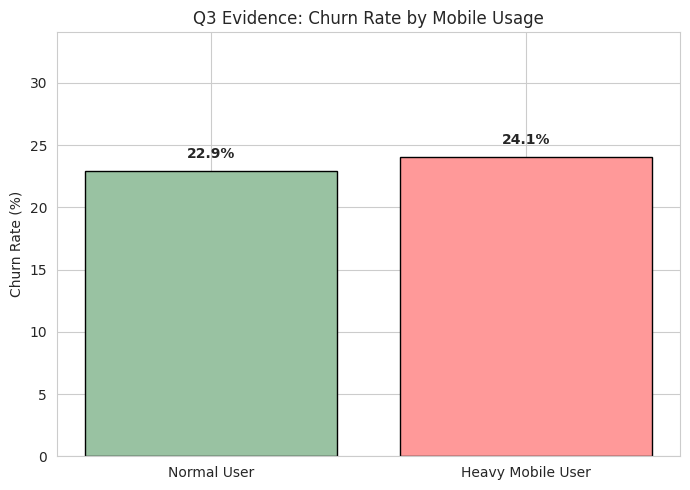

In [32]:
# ============================================
# SECTION 8: EVIDENCE FOR BUSINESS QUESTION 3
# ============================================
# # --- Create Evidence for Q3 (Mobile Risk) ---
plt.figure(figsize=(7, 5))

# Calculate churn rate for Heavy (>70% usage) vs Normal users
mobile_risk = df.groupby('heavy_mobile_user')['is_churned'].mean() * 100
colors_mobile = ['#99c2a2', '#ff9999'] # Green (Safe) vs Red (Risk)

# Plot
plt.bar(
    x=['Normal User', 'Heavy Mobile User'],
    height=mobile_risk.values,
    color=colors_mobile,
    edgecolor='black'
)

plt.title("Q3 Evidence: Churn Rate by Mobile Usage")
plt.ylabel("Churn Rate (%)")
plt.ylim(0, max(mobile_risk.values) + 10) # Add headroom for labels

# Add the percentages on top
for i, v in enumerate(mobile_risk.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

**Figure 12: Churn Rate by Mobile Usage Intensity**
> Heavy mobile users churn more (24.1%) than normal users (22.9%), suggesting mobile-experience friction.

### **Q4: What factors most strongly influence churn?**
In the tuned logistic regression, churn risk is driven mainly by **customer context variables** rather than raw usage volume. The largest coefficient signals highlight **promotional exposure** (directionally churn-reducing), **loyalty status** (`is_loyal`), and **geography** (with **India** associated with higher churn risk and **Germany** with lower). Engagement features such as `watch_per_fee_ratio` and mobile usage contribute, but appear as secondary signals in the tuned coefficient ranking.

*(See the “Model-based drivers of churn” figure in the portfolio notebook.)*


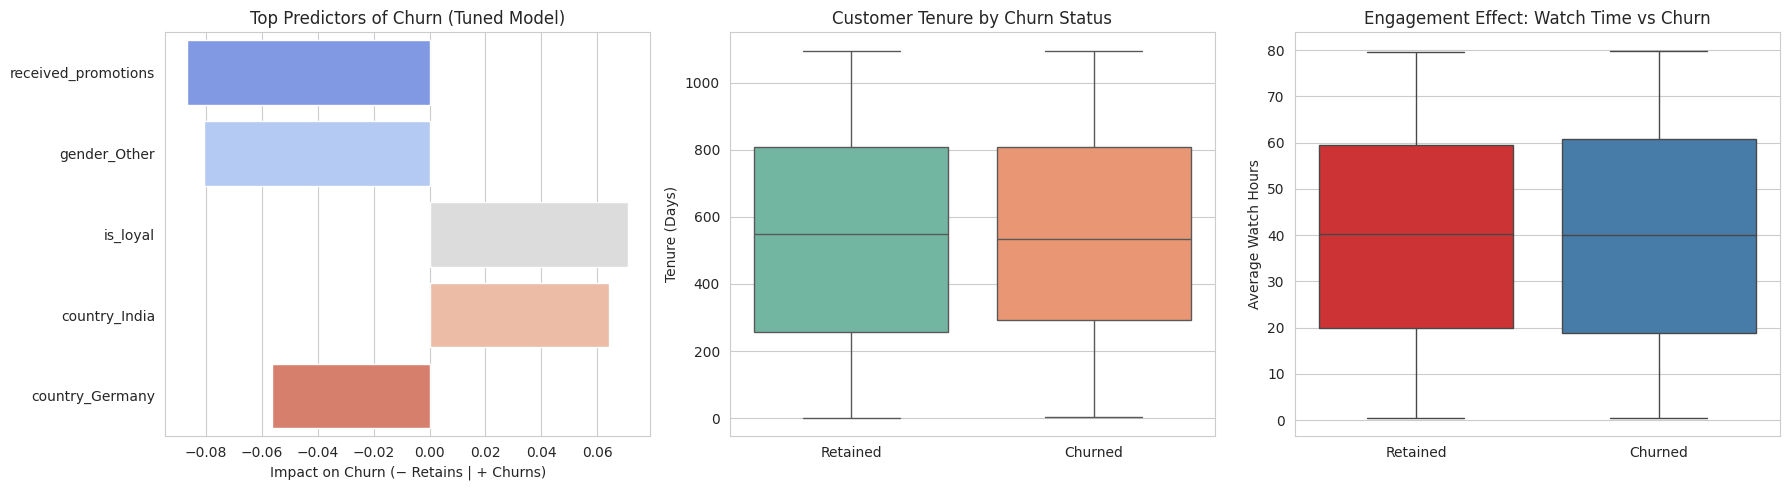

In [33]:
# ==========================================
# SECTION 8: VISUAL EVIDENCE FOR QUESTION 4
# ==========================================

# --- Q4: Composite Visual for Business Insights ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# -------------------------------
# CHART 1: Model Evidence (Coefficients)
# -------------------------------

features = X_train.columns   # matches the training columns
coefficients = best_lr['lr'].coef_[0]

coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": coefficients
})
coef_df["Abs_Coef"] = coef_df["Coefficient"].abs()
top_features = coef_df.sort_values("Abs_Coef", ascending=False).head(5)

sns.barplot(
    data=top_features,
    x="Coefficient",
    y="Feature",
    hue="Feature",
    palette="coolwarm",
    legend=False,
    ax=axes[0]
)

axes[0].set_title("Top Predictors of Churn (Tuned Model)")
axes[0].set_xlabel("Impact on Churn (− Retains | + Churns)")
axes[0].set_ylabel("")

# -------------------------------
# CHART 2: Key Driver Illustration (Tenure)
# -------------------------------
sns.boxplot(
    data=df,
    x="is_churned",
    y="tenure_days",
    hue="is_churned",
    palette="Set2",
    legend=False,
    ax=axes[1]
)

axes[1].set_title("Customer Tenure by Churn Status")
axes[1].set_xlabel("")
axes[1].set_ylabel("Tenure (Days)")
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(["Retained", "Churned"])

# -------------------------------
# CHART 3: Engagement Illustration (Watch Time)
# -------------------------------
sns.boxplot(
    data=df,
    x="is_churned",
    y="average_watch_hours",
    hue="is_churned",
    palette="Set1",
    legend=False,
    ax=axes[2]
)

axes[2].set_title("Engagement Effect: Watch Time vs Churn")
axes[2].set_xlabel("")
axes[2].set_ylabel("Average Watch Hours")
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(["Retained", "Churned"])

plt.tight_layout()
plt.show()

 **Figure 13: Model-based Drivers of Churn (Tuned Logistic Regression)**
> The left panel displays the most influential coefficients from the tuned logistic regression model, highlighting both churn-increasing and churn-reducing factors. **Loyalty status (`is_loyal`)** emerges as the strongest retention driver, with loyal users significantly less likely to churn. **Promotional exposure (`received_promotions`)** is also negatively associated with churn, confirming promotions as a protective factor. **Geographic effects** are material, with users from **India** exhibiting higher churn risk and users from **Germany** showing lower risk. Other variables, such as gender, have comparatively minor influence.

> The middle panel compares **customer tenure** by churn status. While retained users show a slightly higher median tenure, the distributions overlap substantially, indicating that tenure alone is a weak discriminator between churned and retained users.

> The right panel examines **average watch time** by churn status. Engagement levels are broadly similar across both groups, reinforcing that raw watch hours are not a strong standalone predictor of churn in the tuned model.

> **Overall insight:**
The tuned model relies primarily on **structural and contextual factors** (loyalty, geography, promotional exposure) rather than raw engagement or tenure metrics, underscoring the importance of customer context over usage volume alone.

---

### **Q5: Which segments should retention prioritise?**

Prioritise users flagged as predicted churn by the tuned model (Figure 9). Because precision is low, start with low-cost interventions, reserving discounts for smaller, higher-confidence cohorts.

> **Business implication:** Deploy low-cost interventions (notifications, content nudges) broadly, reserving expensive incentives for confirmed high-risk cohorts.

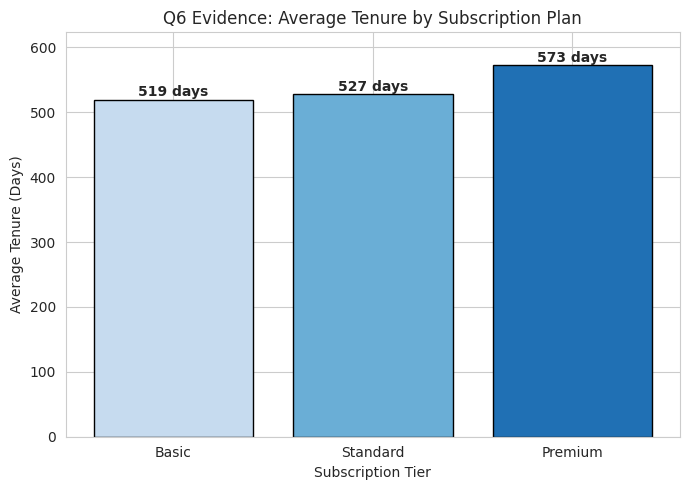

In [34]:
# ============================================
# SECTION 8: EVIDENCE FOR BUSINESS QUESTION 6
# ============================================

# --- Q6: Visual Showing Tenure Drivers ---
plt.figure(figsize=(7, 5))

# Calculate average tenure per plan
plan_tenure = df.groupby('subscription_type')['tenure_days'].mean().sort_values()
colors_plan = sns.color_palette("Blues", n_colors=3)

# Plot
plt.bar(
    x=plan_tenure.index,
    height=plan_tenure.values,
    color=colors_plan,
    edgecolor='black'
)

plt.title("Q6 Evidence: Average Tenure by Subscription Plan")
plt.ylabel("Average Tenure (Days)")
plt.xlabel("Subscription Tier")
plt.ylim(0, max(plan_tenure.values) + 50) # Add headroom for labels

# Add days on top
for i, v in enumerate(plan_tenure.values):
    plt.text(i, v + 5, f"{int(v)} days", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

**Figure 14: Average Tenure by Subscription Plan**

> Average tenure increases with subscription tier, with Premium users exhibiting the longest retention, followed by Standard and Basic plans.

In [35]:
# Check R2 score for the Tenure Model
print(f"R-Squared Score: {reg.score(Xr_test_s, yr_test):.3f}")

R-Squared Score: -0.044


**Interpretation Note:**  
The negative R² value indicates that tenure is not linearly predictable from demographic variables alone, reinforcing the complexity of customer lifecycle behavior.

---

### **Q6: What factors affect tenure?**
Tenure is **not well explained by a linear model** using the available features (R² = −0.044). The tier comparison (Figure 14) suggests Premium users stay longer on average, but tenure behaviour likely reflects non-linear and unobserved factors (content fit, service experience, lifecycle stage).

> **Interpretation:** Customer lifecycle behaviour is complex and non-linear. While engagement and experience quality influence tenure directionally, no simple linear rule explains longevity, limiting the usefulness of point forecasts for tenure duration.

---
---